<a href="https://colab.research.google.com/github/lhyochan7/MRI-analysis/blob/main/3D_MRI_pix2pix_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patchify
import nibabel as nib
import tensorflow as tf
import numpy as np
import os
import glob
import time
import datetime
from nibabel.viewers import OrthoSlicer3D


from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv3D
from keras.layers import Conv3DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from numpy import savez_compressed


# **Preprocessing of Nifti file**



In [2]:
org_list = []
tar_list = []

for org_file in glob.glob('/content/drive/MyDrive/Data/Original/*.gz'):
  org_base = os.path.basename(org_file)
  org_base = org_base[0:15]
  for tar_file in glob.glob('/content/drive/MyDrive/Data/Target/*.gz'):
    tar_base = os.path.basename(tar_file)
    tar_base = tar_base[0:15]
    
    if tar_base == org_base:
      org_img = nib.load(org_file)
      tar_img = nib.load(tar_file)

      # convert nii file to numpy array
      data1 = org_img.get_fdata()
      data2 = tar_img.get_fdata()

      org_list.append(data1)
      tar_list.append(data2)

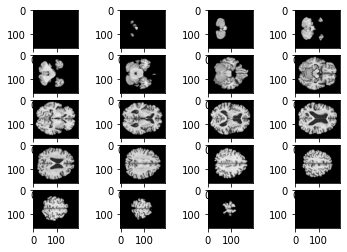

In [3]:
# Example slices of original data
width,height,queue=org_img.dataobj.shape

num=1
for i in range(0,queue,8):#You can also take 10 etc.
    img_arr=org_img.dataobj[:,:,i]
    plt.subplot(5,4,num)
    plt.imshow(img_arr,cmap='gray')
    num+=1
plt.show()


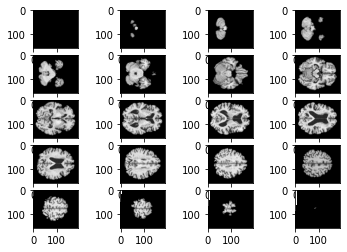

In [4]:
# Example slices of target data
width,height,queue=tar_img.dataobj.shape

num=1
for i in range(0,queue,8):#You can also take 10 etc.
    img_arr=tar_img.dataobj[:,:,i]
    plt.subplot(5,4,num)
    plt.imshow(img_arr,cmap='gray')
    num+=1

plt.show()

10
10
shape of dataset items:  (80, 64, 64, 64, 1)


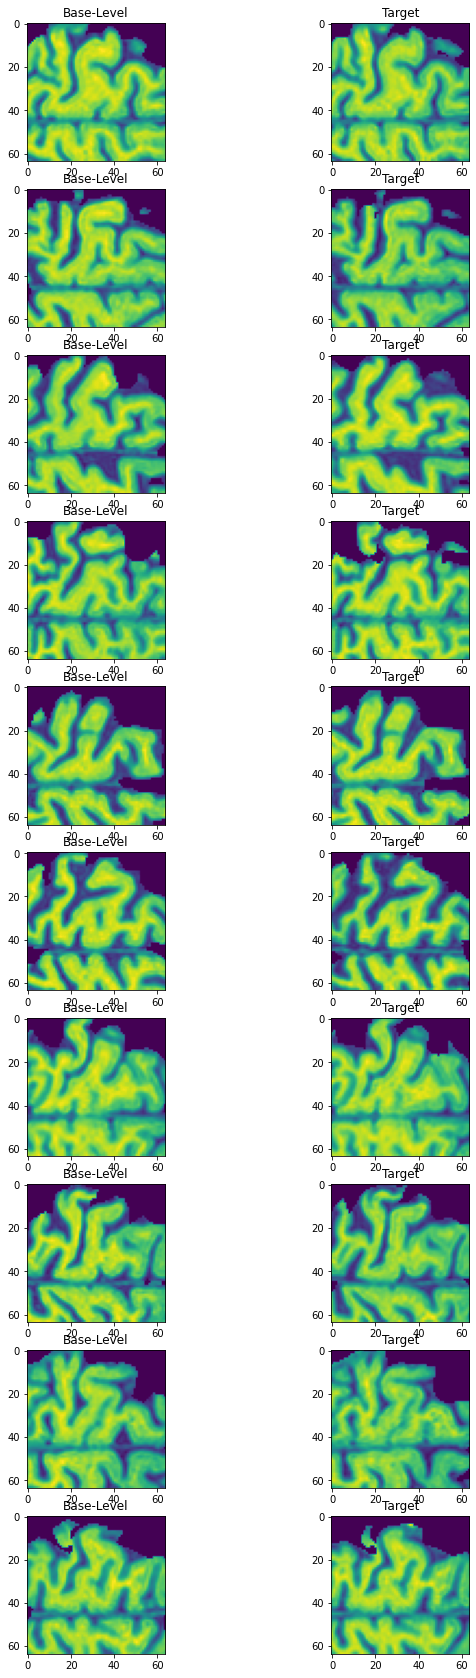

In [5]:
o_dataset = []
t_dataset = []

fig = plt.figure(figsize=(10,30))

num = 1

# patchify and convert to tensor
for o_data in org_list:
  src_patches = patchify(o_data, (64,64,64), step = 32)
  
  ax1 = fig.add_subplot(len(org_list),2,num)
  ax1.set_title('Base-Level')
  ax1.imshow(src_patches[1,2,3,:,:,40])
  num += 2
  

  # combine vectors 4 x 5 x 4 to 80 patches
  input_img = np.reshape(src_patches, (-1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5], 1)) # n_patches, x, y, z
  input_img = tf.convert_to_tensor(input_img, np.float32)
  o_dataset.append(input_img)

num = 2

# patchify and convert to tensor
for t_data in tar_list:
  target_patches = patchify(t_data, (64,64,64), step = 32)  
  
  ax2 = fig.add_subplot(len(tar_list),2,num)
  ax2.set_title('Target')
  ax2.imshow(target_patches[1,2,3,:,:,40])
  num += 2
  
  
  # combine vectors 4 x 5 x 4 to 80 patches
  input_img = np.reshape(src_patches, (-1, src_patches.shape[3], src_patches.shape[4], src_patches.shape[5], 1)) # n_patches, x, y, z
  input_img = tf.convert_to_tensor(input_img, np.float32)
  t_dataset.append(input_img)



# 80 patches for each image in each list  ex) o_dataset[0][1,2,3,:,:,32]
print(len(o_dataset))
print(len(t_dataset))


savez_compressed('dataset.npz', o_dataset, t_dataset)

print("shape of dataset items: " ,o_dataset[1].shape)

#src_patches = patchify(a, (64,64,64), step = 32)
#target_patches = patchify(tar_data, (64,64,64), step = 32)

# **Generator Model**

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 32, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32, 6 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 16, 16, 1 221312      leaky_re_lu[0][0]                
______________________________________________________________________________________________

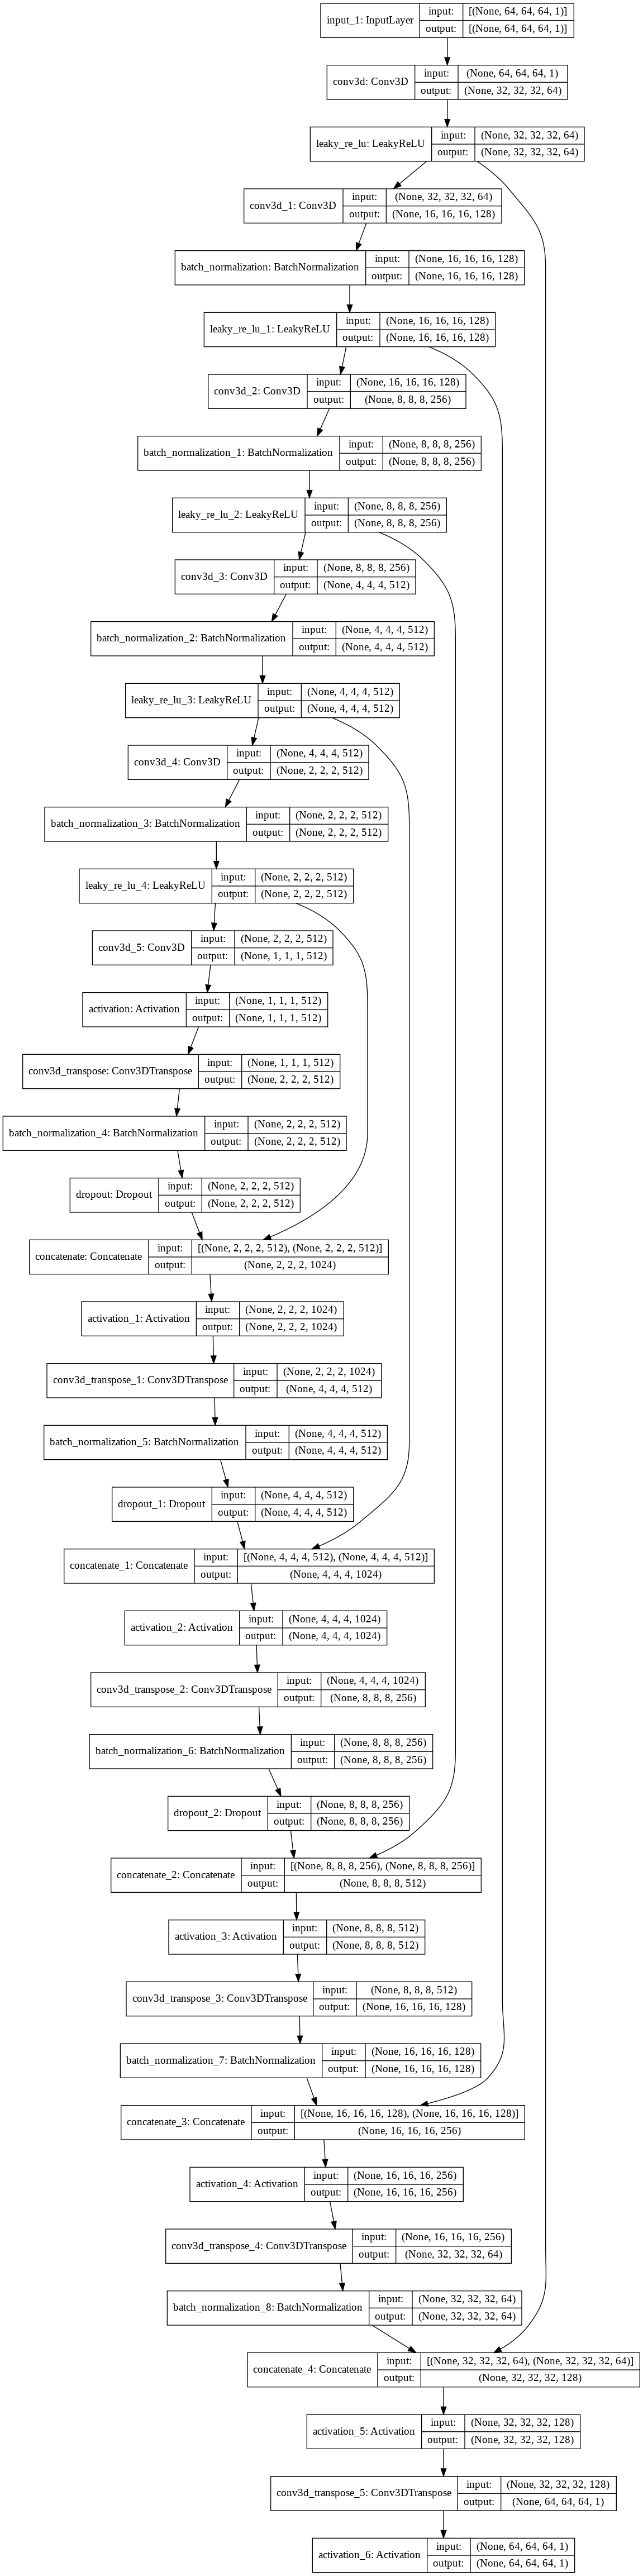

In [6]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv3D(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv3DTranspose(n_filters, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
  #image_shape = tf.convert_to_tensor(image_shape, np.float32)
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	
	# bottleneck, no batch norm and relu
	b = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(e5)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e5, 512)
	d2 = decoder_block(d1, e4, 512)
	d3 = decoder_block(d2, e3, 256)
	d4 = decoder_block(d3, e2, 128, dropout=False)
	d5 = decoder_block(d4, e1, 64, dropout=False)

	# output
	g = Conv3DTranspose(1, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model
 
g_model = define_generator((o_dataset[0].shape[1:]))
g_model.summary()
tf.keras.utils.plot_model(g_model, show_shapes=True, show_layer_names=True)

# **Generator Ver2**

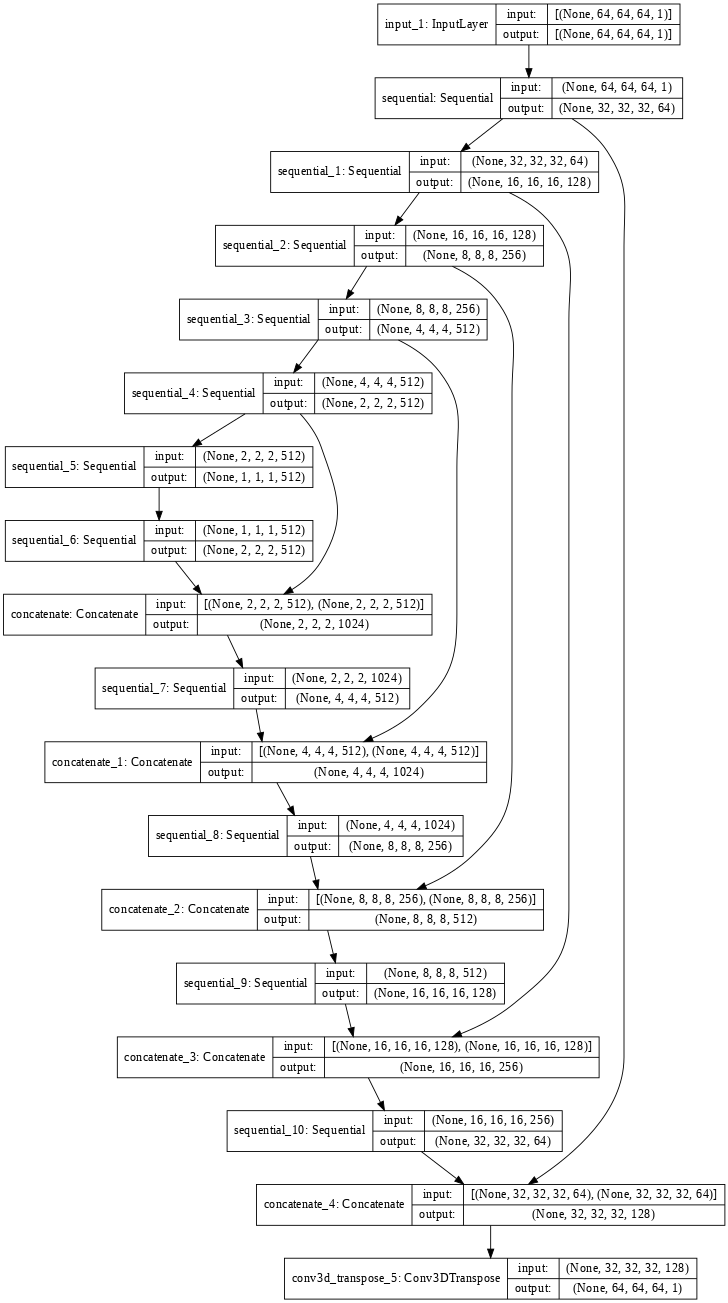

In [7]:
OUTPUT_CHANNELS = 1

def downsample(n_filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv3D(n_filters, size, (2,2,2), padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(n_filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv3DTranspose(n_filters, size, strides=(2,2,2),
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[64,64,64,1])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size,64,64,64,1)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)

    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=(2,2,2),
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


# **Discriminator Model**


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


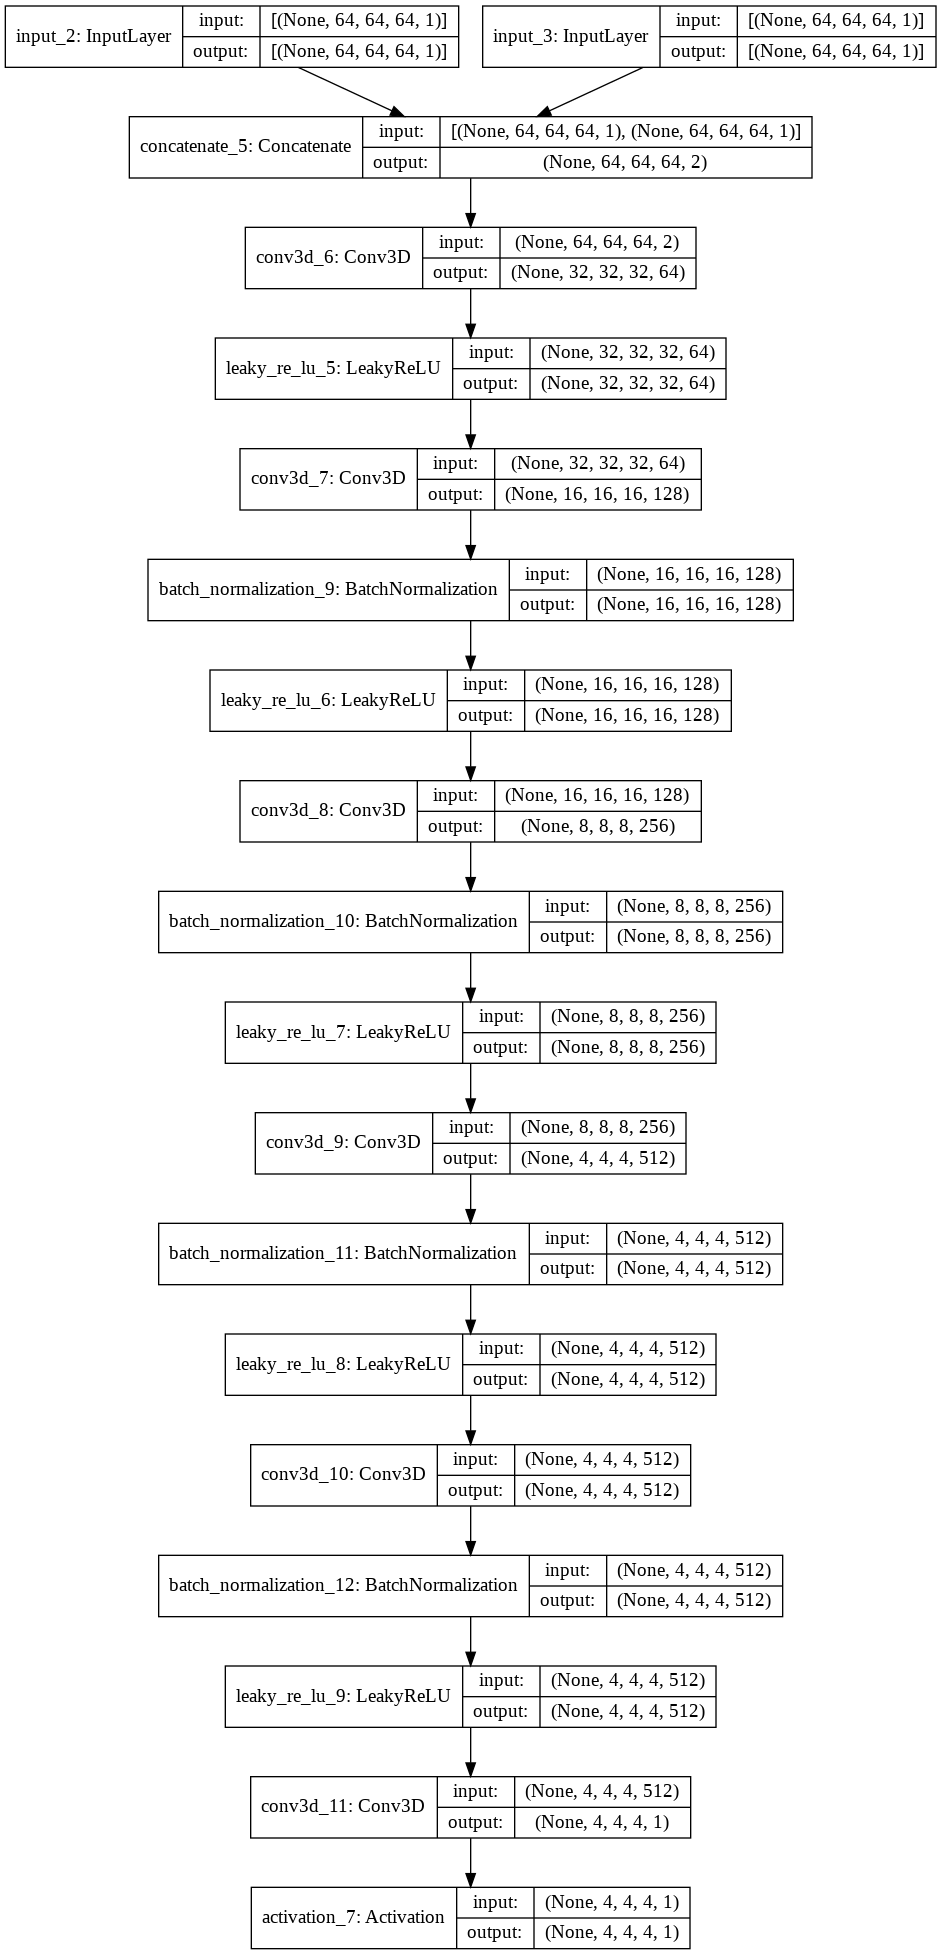

In [8]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv3D(64, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv3D(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv3D(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv3D(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
  
	# second last output layer
	d = Conv3D(512, (3,3,3), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv3D(1, (3,3,3), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

d_model = define_discriminator((o_dataset[0].shape[1:]))
tf.keras.utils.plot_model(d_model, show_shapes=True, show_layer_names=True)

# **Discriminator Ver2**

In [10]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[64,64,64,1], name='input_image')
  tar = tf.keras.layers.Input(shape=[64,64,64,1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 3, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 3)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 3)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding3D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv3D(512, 3, strides=2,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding3D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv3D(1, 3, strides=2,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

NameError: ignored

# **Define GAN**

In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


gan_model = define_gan(g_model, d_model, o_dataset[0].shape[1:])
tf.keras.utils.plot_model(gan_model, show_shapes=True, show_layer_names=True)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64, 64, 64, 1 59043521    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 4, 4, 4, 1)   11747137    input_4[0][0]                    
                                                                 model[0][0]                      
Total params: 70,790,658
Trainable params: 59,040,577
Non-trainable params: 11,750,081
__________________________________________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Test Generator and Discriminator**

In [12]:
# Original src_patch (4,5,4,64,64,64)
print("Input shape: " , src_patches.shape)

# input shape = (64,64,64)
g_model = define_generator((input_img.shape[1:]))
d_model = define_discriminator((input_img.shape[1:]))

predicted_patches = []
discr_patches = []

for i in range(src_patches.shape[0]):
  for j in range(src_patches.shape[1]):
    for k in range(src_patches.shape[2]):
      single_patch = src_patches[i,j,k, :,:,:]  # (64, 64, 64)
      single_patch = np.reshape(single_patch, (-1, single_patch.shape[0], single_patch.shape[1], single_patch.shape[2], 1))
      
      single_patch_pred = generator.predict(single_patch)
      single_patch_discr = discriminator.predict([single_patch, single_patch_pred])

      #single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
      
      predicted_patches.append(single_patch_pred)
      discr_patches.append(single_patch_discr)

Input shape:  (4, 5, 4, 64, 64, 64)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
predicted_patches = np.array(predicted_patches)
print("Generator output before reshape:", predicted_patches.shape)
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (src_patches.shape[0], src_patches.shape[1], src_patches.shape[2],
                                         src_patches.shape[3], src_patches.shape[4], src_patches.shape[5]) )


print("Discriminator output shape:", discr_patches[3].shape)

print("Generator output after reshape:", predicted_patches_reshaped.shape)

Generator output before reshape: (80, 1, 64, 64, 64, 1)
Discriminator output shape: (1, 2, 2, 2, 1)
Generator output after reshape: (4, 5, 4, 64, 64, 64)


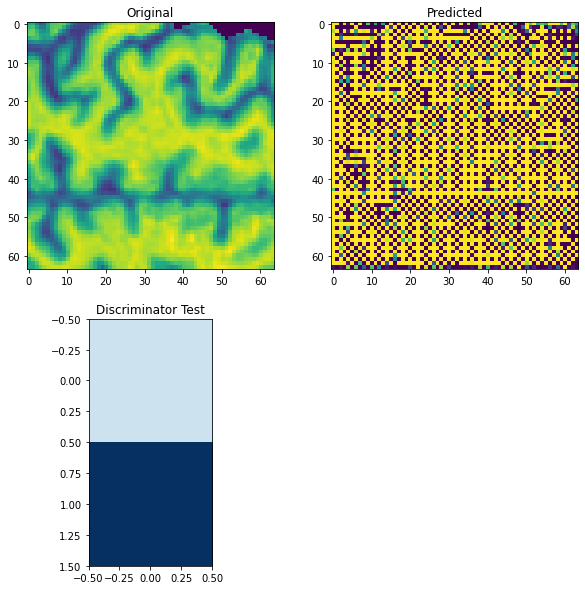

In [14]:
fig = plt.figure(figsize=(10,10))

# Original Patch
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Original')
ax1.imshow(src_patches[1,2,3,:,:,32])

# Predicted Patch (No training)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Predicted')
ax2.imshow(predicted_patches_reshaped[1,2,3,:,:,32])

# Discriminator Test
a = discr_patches[0]


ax3 = fig.add_subplot(2,2,3)
ax3.set_title('Discriminator Test')
ax3.imshow(a[0,1,:,1], vmin=-20, vmax=20, cmap='RdBu_r')

# **Define Generator and Discriminator Loss**

In [15]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [17]:
# define optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [18]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = ddiscriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
  

In [19]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      start = time.time()
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [20]:
fit(o_dataset, t_dataset, steps=40000)

AttributeError: ignored

# Training Version 2


In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

dataset = load_real_samples('dataset.npz')

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset
  #print("trainA shape", trainA.shape)
  #print("trainB shape", trainB.shape)
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)

  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]

  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, patch_shape, 1))    
  return [X1, X2], y  # random pair of images with label class=1 to indicate real


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance

  sample_instances = []
  predicted_patches = []

  # reshape each sample instance in samples list
  for count in range(samples.shape[0]):
    print(count)
    instance = samples[count]
    print(instance.shape)
    sample_instance = np.reshape(instance, 
                                        (4,5,4,64,64,64) )
    
    print("sample instance shape:", sample_instance.shape)
    sample_instances.append(sample_instance)

  # Predict each patch for each sample in samples list
  for count in range(len(sample_instances)):
    for i in range(sample_instance.shape[0]):
      for j in range(sample_instance.shape[1]):
        for k in range(sample_instance.shape[2]):
          inst = sample_instances[count]

          single_patch = inst[i,j,k, :,:,:]  # (64, 64, 64)
          single_patch = np.reshape(single_patch, (-1, single_patch.shape[0], single_patch.shape[1], single_patch.shape[2], 1))
          single_patch_pred = g_model.predict(single_patch)

          #single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
          predicted_patches.append(single_patch_pred)

  # Reshape each predicted patch into (n_samples, 80, 64, 64 ,64 ,1)
  predicted_patches = np.array(predicted_patches)
  predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (samples.shape[0], 80, 64, 64, 64, 1))  

  print("predicted_patches shape: ", predicted_patches_reshaped.shape)
  # create 'fake' class labels (0)
  y = zeros((samples.shape[0], patch_shape, patch_shape, patch_shape, 1))  #deleted 1 at the end
  
  return predicted_patches_reshaped, y   # generator output with label class=0 to indicate fake


In [ ]:
patch_shape = d_model.output_shape[1]

[rx, rx1], ry = generate_real_samples(dataset, 1, patch_shape)
print("rx shape: ",rx.shape)
print("ry shape: ",ry[0].shape)


fx, fy = generate_fake_samples(g_model, rx, patch_shape)
print("fx shape: ",fx.shape)
print("fy shape: ",fy[0].shape)



In [ ]:
rx = np.reshape(rx, (4,5,4,64,64,64) )
fx = np.reshape(fx, (4,5,4,64,64,64) )

fig = plt.figure(figsize=(10,10))


test3 = np.reshape(test2, (4,5,4,64,64,64) )

# Original Patch
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Original')
ax1.imshow(rx[1,2,3,:,:,32])

# Predicted Patch (No training)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Predicted')
ax2.imshow(fx[1,2,3,:,:,32])

In [ ]:
def reshape(samples, shape):
  
  reshaped = np.reshape(samples,(shape))
  
  return reshaped


# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=5, n_batch=1):
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs

  shape = (4,5,4,64,64,64)

  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    
    #print("HERE111", X_realA.shape)
    #print(y_real.shape)
    #X_realA = reshape(X_realA, shape)    
    # generate a batch of fake samples

    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

    #print("X_realA before reshape: ", X_realA.shape)
    X_realA = reshape(X_realA, shape)
    X_realB = reshape(X_realB, shape)
    X_fakeB = reshape(X_fakeB, shape)


    fig = plt.figure(figsize=(15,10))
    # Original Patch
    ax1 = fig.add_subplot(2,3,1)
    ax1.set_title('Original')
    ax1.imshow(X_realA[1,2,3,:,:,40])

    # Predicted Patch (No training)
    ax2 = fig.add_subplot(2,3,2)
    ax2.set_title('Predicted')
    ax2.imshow(X_fakeB[1,2,3,:,:,40])
    
    # Predicted Patch (No training)
    ax3 = fig.add_subplot(2,3,3)
    ax3.set_title('Target')
    ax3.imshow(X_realB[1,2,3,:,:,40])

    plt.show()
    #print("X_realA after reshape: ", X_realA.shape)
  
    
    for i in range(X_realA.shape[0]):
      for j in range(X_realA.shape[1]):
        for k in range(X_realA.shape[2]):
          X_realA_patch = X_realA[i,j,k, :,:,:]  # (64, 64, 64)
          X_realB_patch = X_realB[i,j,k, :,:,:]
          X_fakeB_patch = X_fakeB[i,j,k, :,:,:]

          #print(X_realA_patch.shape)
          
          X_realA_patch = np.reshape(X_realA_patch, (-1, X_realA_patch.shape[0], X_realA_patch.shape[1], 
                                                     X_realA_patch.shape[2], 1))
                                                     
          X_realB_patch = np.reshape(X_realB_patch, (-1, X_realB_patch.shape[0], X_realB_patch.shape[1], 
                                                     X_realB_patch.shape[2], 1))

          X_fakeB_patch = np.reshape(X_fakeB_patch, (-1, X_fakeB_patch.shape[0], X_fakeB_patch.shape[1], 
                                                     X_fakeB_patch.shape[2], 1))
          #print(X_realA_patch.shape)
          # update discriminator for real samples
          
          d_loss1 = d_model.train_on_batch([X_realA_patch, X_realB_patch], y_real)
          
          #print("FakeB shape:", X_fakeB_patch.shape)
          # update discriminator for generated samples
          d_loss2 = d_model.train_on_batch([X_realA_patch, X_fakeB_patch], y_fake)

          # update the generator
          g_loss, _, _ = gan_model.train_on_batch(X_realA_patch, [y_real, X_realB_patch])

          # summarize performance
          print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

    gan_model.save('modelTest.h5')
    
image_shape = input_img.shape[1:]

print(image_shape)
g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

print(d_model.output_shape)

train(d_model, g_model, gan_model, dataset)

# **Test Generator Model after training**

In [ ]:

predicted_patches = []
discr_patches = []

for i in range(src_patches.shape[0]):
  for j in range(src_patches.shape[1]):
    for k in range(src_patches.shape[2]):
      single_patch = src_patches[i,j,k, :,:,:]  # (64, 64, 64)
      single_patch = np.reshape(single_patch, (-1, single_patch.shape[0], single_patch.shape[1], single_patch.shape[2], 1))
      
      single_patch_pred = g_model.predict(single_patch)
      single_patch_discr = d_model.predict([single_patch, single_patch_pred])

      #single_patch_pred_argmax = np.argmax(single_patch_pred, axis=4)[0,:,:,:]
      
      predicted_patches.append(single_patch_pred)
      discr_patches.append(single_patch_discr)


predicted_patches = np.array(predicted_patches)
print("Generator output before reshape:", predicted_patches.shape)
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (src_patches.shape[0], src_patches.shape[1], src_patches.shape[2],
                                         src_patches.shape[3], src_patches.shape[4], src_patches.shape[5]) )


print("Discriminator output shape:", discr_patches[3].shape)

print("Generator output after reshape:", predicted_patches_reshaped.shape)


fig = plt.figure(figsize=(10,10))

# Original Patch
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Original')
ax1.imshow(src_patches[1,2,3,:,:,32])

# Predicted Patch (No training)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Predicted')
ax2.imshow(predicted_patches_reshaped[1,2,3,:,:,32])


In [ ]:
reconstructed_image = unpatchify(predicted_patches_reshaped, org_img.shape)
print(reconstructed_image.shape)

#print(reconstructed_image)

# to save this 3D (ndarry) numpy use this
img = nib.Nifti1Image(reconstructed_image, np.eye(4))  # Save axis for data (just identity)

img.header.get_xyzt_units()
img.to_filename(os.path.join('/content/drive/MyDrive/Data', 'Reconstructed_image.nii.gz'))  # Save as NiBabel file

# **논문 mi-GAN model**

In [ ]:
def u_net_bn3d_mi(x,y,is_train=False,reuse=False,is_refine=False):

  w_init = tf.truncated_normal_initializer(stddev=0.01)
  b_init = tf.constant_initializer(value=0.0)
  gamma_init = tf.random_normal_initializer(1., 0.02)
  df_dim=64
  v=y[:,np.newaxis,np.newaxis,np.newaxis,:]

  with tf.variable_scope("u_net3d_mi", reuse=reuse):
    tl.layers.set_name_reuse(reuse)
    inputs=tl.layers.InputLayer(x,name='input')
    inputs1=tl.layers.InputLayer(y,name='inputmi')
    conv1 = tl.layers.Conv3dLayer(inputs, shape=(4,4,4,1,df_dim), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv1')
    conv1 = tl.layers.BatchNormLayer(conv1, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn1')

    conv2 = tl.layers.Conv3dLayer(conv1, shape=(4,4,4,df_dim,df_dim*2), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv2')
    conv2 = tl.layers.BatchNormLayer(conv2, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn2')

    conv3 = tl.layers.Conv3dLayer(conv2, shape=(4,4,4,df_dim*2,df_dim*4), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv3')
    conv3 = tl.layers.BatchNormLayer(conv3, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn3')

    conv4 = tl.layers.Conv3dLayer(conv3, shape=(4,4,4,df_dim*4,df_dim*8), stride=(1,2,2,2,1), 
                                  padding='SAME', act=None, W_init=winit, b_init=b_init, name='conv4')
    conv4 = tl.layers.BatchNormLayer(conv4, act=lambda x:tl.act.lrelu(x, 0.2), 
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn4')
    
    conv5 = tl.layers.Conv3dLayer(conv4, shape=(5,6,5,df_dim*8, 509), strides=(1,8,8,8,1), padding='VALID', act=None,
                                  W_init=w_init, b_init=b_init, name='conv5')
    
    conv5 = tl.layers.ConcatLayer([conv5, inputs1], concat_dim=4, name='concat6') # Concat multi-info

    conv5 = tl.layers.BatchNormLayer(conv5, act=lambda x: tl.act.lrelu(x,0.2),
                                     ls_train=ls_train, gamma_init=gamma_init, name='bn5')
    
    up5 = tl.layers.DeConv3d(conv5, df_dim*8, (5,6,5), strides=(5,6,5), padding='VALID', act=None,
                             W_init=w_init, b_init=b_init, name='deconv5')
    up5 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_train,
                                   gamma_init=gamma_init, name='dbn5')
  
    up4 = tl.layers.ConcatLayer([up5, con4], concat_dim=4, name='concat4')
    up4 = tl.layers.DeConv3d(up4, df_dim*8, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv4')
    up4 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn4')
  
    up3 = tl.layers.ConcatLayer([up4, con3], concat_dim=4, name='concat3')
    up3 = tl.layers.DeConv3d(up4, df_dim*4, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv3')
    up3 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn3')
  
    up2 = tl.layers.ConcatLayer([up3, con2], concat_dim=4, name='concat2')
    up2 = tl.layers.DeConv3d(up4, df_dim*2, (4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv2')
    up2 = tl.layers.BatchNormLayer(up5, act=tf.nn.relu, ls_train=ls_t4ain,
                                   gamma_init=gamma_init, name='dbn2')
  
    up1 = tl.layers.ConcatLayer([up2, con1], concat_dim=4, name='concat1')
    up1 = tl.layers.DeConv3d(up1, 64,(4,4,4), strides=(2,2,2), padding='SAME', act=None,
                             W_init=w_init, b_init=b_init, name='deconv1')
     
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary() 

    

In [ ]:
'''
#def u_net_bn3d_mi(x,y,is_train=False,reuse=False,is_refine=False):
def define_generator(image_shape):

  
  #w_init = tf.keras.initializers.TruncatedNormal(stddev=0.01)
  #b_init = tf.constant_initializer(value=0.0)
  #gamma_init = tf.random_normal_initializer(1., 0.02)
  #df_dim=64
  #v=y[:,np.newaxis,np.newaxis,np.newaxis,:]
  

  init = RandomNormal(stddev=0.02)
  df_dim = 64

  #with tf.variable_scope("u_net3d_mi", reuse=reuse):
  #tl.layers.set_name_reuse(reuse)
  
  in_image = Input(shape=image_shape)
  print(in_image.shape)
  #inputs=tf.keras.layers.InputLayer(image_shape, name='input')

  print(in_image.shape)

  #inputs1=tl.layers.InputLayer(y,name='inputmi')
  conv1 = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(in_image)
  conv1 = BatchNormalization()(conv1, training=True)
  conv1 = LeakyReLU(alpha=0.2)(conv1)

  conv2 = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv1)
  conv2 = BatchNormalization()(conv2, training=True)
  conv2 = LeakyReLU(alpha=0.2)(conv2)

  conv3 = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv2)
  conv3 = BatchNormalization()(conv3, training=True)
  conv3 = LeakyReLU(alpha=0.2)(conv3)

  conv4 = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(conv3)
  conv4 = BatchNormalization()(conv4, training=True)
  conv4 = LeakyReLU(alpha=0.2)(conv4)

  conv5 = Conv3D(512, (4,4,4), strides=(8,8,8), padding='valid', kernel_initializer=init)(conv4)  #originall (5,6,5)
  conv5 = BatchNormalization()(conv5, training=True)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  up5 = Conv3DTranspose(512, (4,4,4), strides=(2,2,2), padding='valid', kernel_initializer=init)(conv5) #originally (5,6,5) strides = (5,6,5)
  up5 = BatchNormalization()(up5, training=True)
 
  up4 = Concatenate([up5, conv4])
  up4 = Conv3DTranspose(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up5)
  up4 = BatchNormalization()(up4, training=True)  
  up4 = LeakyReLU(alpha=0.2)(up4)

  up3 = Concatenate([up4, conv3])
  up3 = Conv3DTranspose(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up4)
  up3 = BatchNormalization()(up3, training=True)  
  up3 = LeakyReLU(alpha=0.2)(up3)

  up2 = Concatenate([up3, conv2])
  up2 = Conv3DTranspose(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up3)
  up2 = BatchNormalization()(up2, training=True)  
  up2 = LeakyReLU(alpha=0.2)(up2)

  up1 = Concatenate([up2, conv1])
  up1 = Conv3DTranspose(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(up2)
  up1 = BatchNormalization()(up1, training=True)  
  up1 = LeakyReLU(alpha=0.2)(up1)

  final = Conv3D(1, (1,1,1), strides=(1,1,1), padding='same', kernel_initializer=init)(up1)
  out_image = Activation('tanh')(final)
	# define model
  model = Model(in_image, out_image)  
  return model
  
  

print(input_img.shape[1:])
g_model = define_generator((input_img.shape[1:]))
tf.keras.utils.plot_model(g_model, show_shapes=True, show_layer_names=True)
g_model.summary()
'''